In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("max_columns", None)

In [3]:
listings = pd.read_csv("../data/dc_listings.csv")

In [4]:
listings.head(1)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,7087327,Historic DC Condo-Walk to Capitol!,15830506,Lize & Greg,NaN,"Capitol Hill, Lincoln Park",38.890046,-77.002808,Entire home/apt,160,1,0,NaN,NaN,18,283


In [5]:
len(listings)

3723

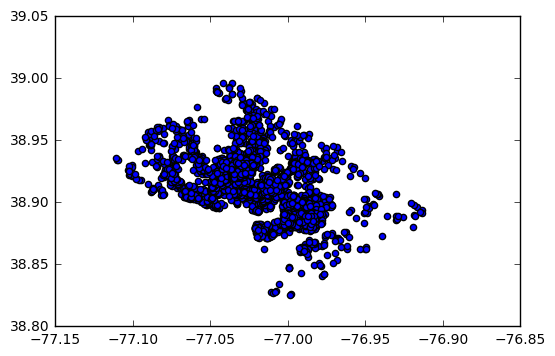

In [6]:
plt.scatter(listings['longitude'], listings['latitude'])


In [7]:
import mplleaflet

sample = listings.sample(1000)
plt.scatter(sample['longitude'], sample['latitude'])

mplleaflet.display()

# Geo Pandas

In [9]:
import geopandas as gpd


In [50]:
dc = gpd.read_file("../data/dc2015.shp")


In [51]:
dc.head(1)

,geometry
0,"POLYGON ((-77.07941099999999 38.905637, -77.07..."


In [52]:
dc['geometry'].head()


0    POLYGON ((-77.07941099999999 38.905637, -77.07...
1    POLYGON ((-77.07650699999999 38.94221599999999...
2    POLYGON ((-77.028013 38.961226, -77.027889 38....
3    POLYGON ((-77.01968099999999 38.952083, -77.01...
4    POLYGON ((-77.02826 38.931821, -77.02748299999...
Name: geometry, dtype: object

In [53]:
dc.crs


{}

In [54]:
dc.columns

Index(['geometry'], dtype='object')

In [55]:
dc['geometry'].head()

0    POLYGON ((-77.07941099999999 38.905637, -77.07...
1    POLYGON ((-77.07650699999999 38.94221599999999...
2    POLYGON ((-77.028013 38.961226, -77.027889 38....
3    POLYGON ((-77.01968099999999 38.952083, -77.01...
4    POLYGON ((-77.02826 38.931821, -77.02748299999...
Name: geometry, dtype: object

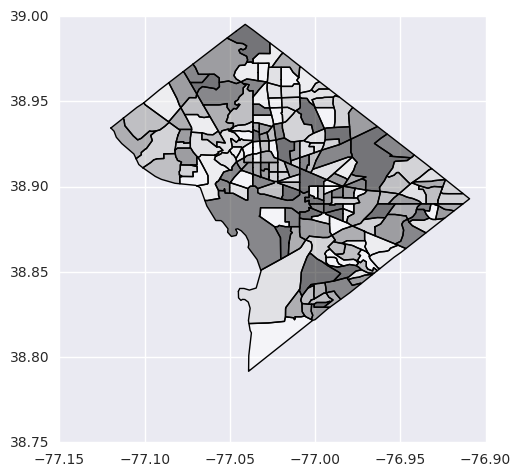

In [56]:
dc.plot()

In [57]:
import mplleaflet

f = plt.figure(figsize=(15, 8))
ax = f.gca()
dc.plot(ax=ax)
mplleaflet.display(fig=f)

## Convert Dataframe to Geodataframe

In [39]:
import shapely

In [58]:
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))

## Using Seaborn to Plot Geometries and Points

In [59]:
import seaborn as sns

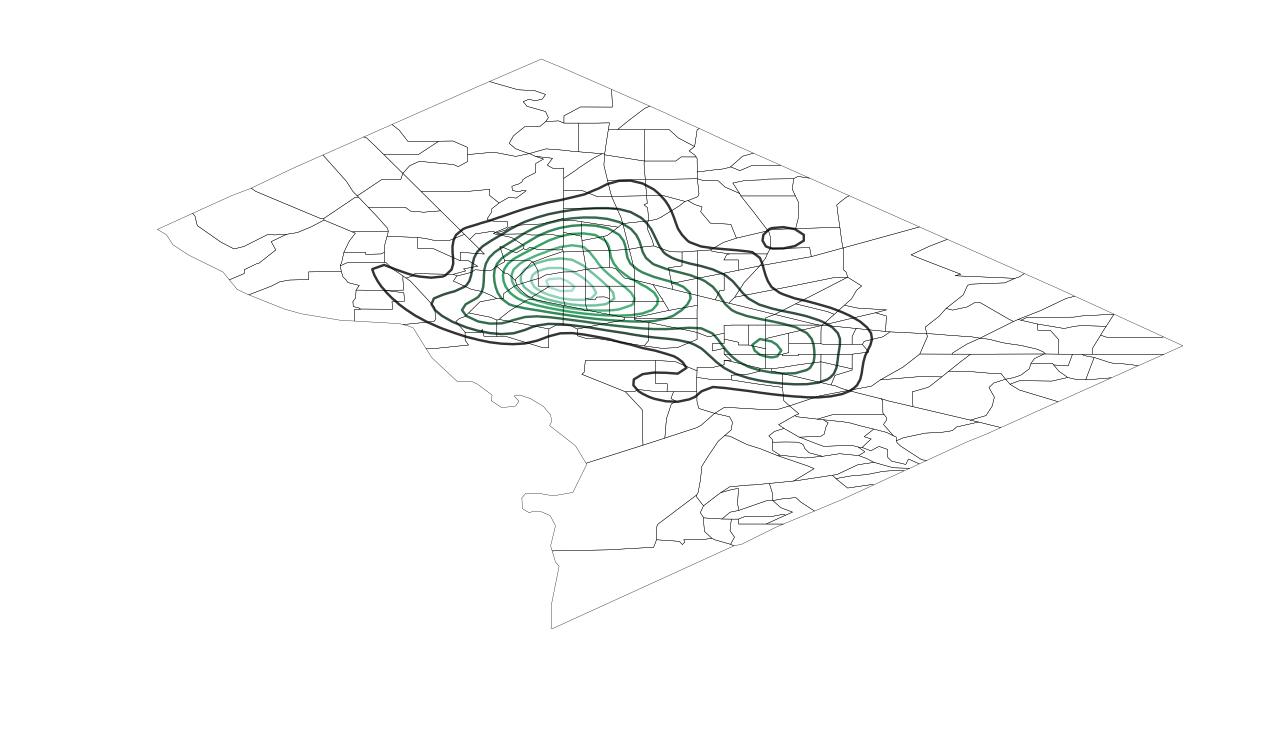

In [60]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
dc.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sns.kdeplot(data=listings.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), ax=ax,
            alpha=1)
ax.set_axis_off()

In [61]:
import numpy as np

def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in dc['geometry']]
    if True in bools:
        return dc.iloc[bools.index(True)]['NAMELSAD10']
    else:
        return np.nan

In [62]:
listings['census_tract'] = listings.apply(assign_census_tract, axis='columns')

KeyError: ('NAMELSAD10', 'occurred at index 0')

In [46]:
listings['census_tract'].value_counts().head()

Series([], Name: census_tract, dtype: int64)

In [52]:
boston['BNBs'] = boston['NAMELSAD10'].map(listings['census_tract'].value_counts())


/usr/local/var/pyenv/versions/3.5.2/envs/python-geospatial-analysis/lib/python3.5/site-packages/pysal/esda/mapclassify.py:259: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/usr/local/var/pyenv/versions/3.5.2/envs/python-geospatial-analysis/lib/python3.5/site-packages/pysal/esda/mapclassify.py:259: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/usr/local/var/pyenv/versions/3.5.2/envs/python-geospatial-analysis/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


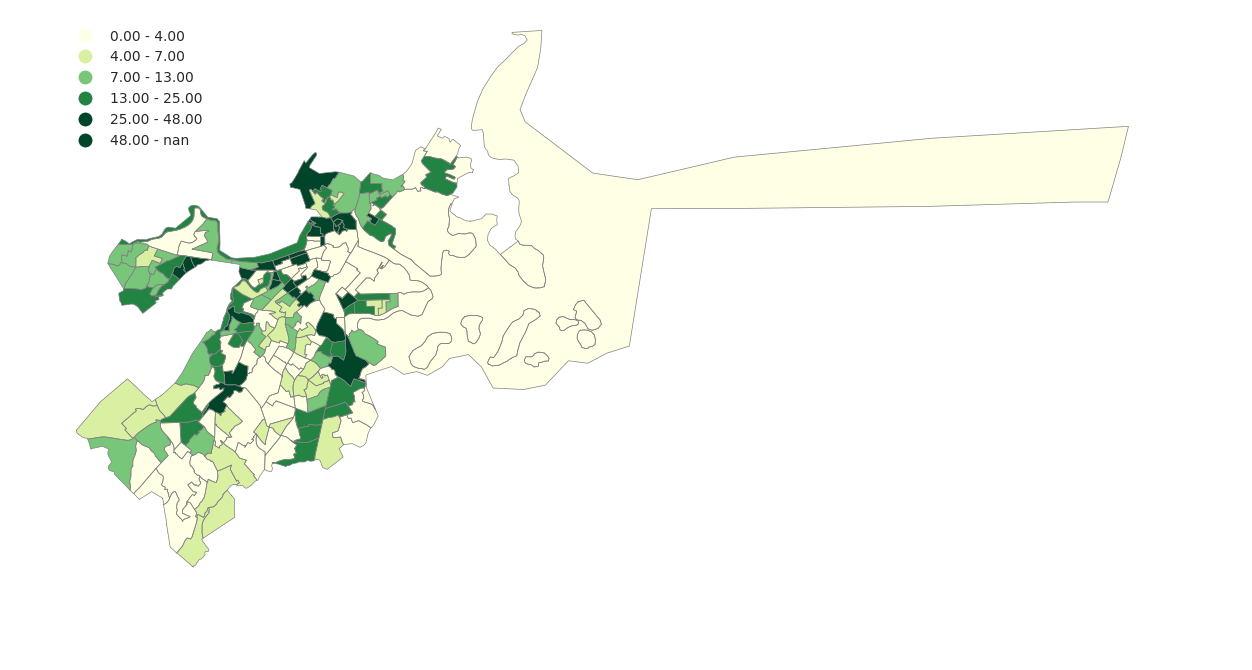

In [54]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBs', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

In [68]:
boston['BNBDensity'] = (boston['BNBs'] / boston['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)).fillna(0)

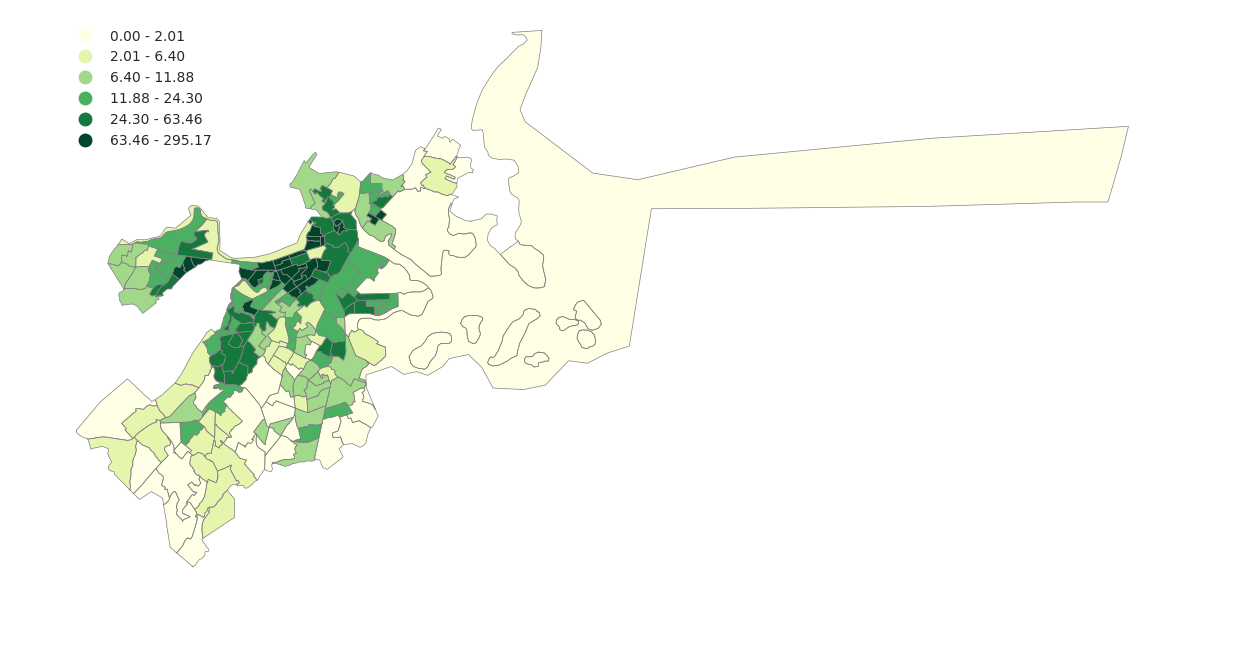

In [58]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBDensity', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

### PySal

In [61]:
import pysal as ps

In [62]:
qW = ps.queen_from_shapefile("../data/input/Census2010_Tracts.shp")


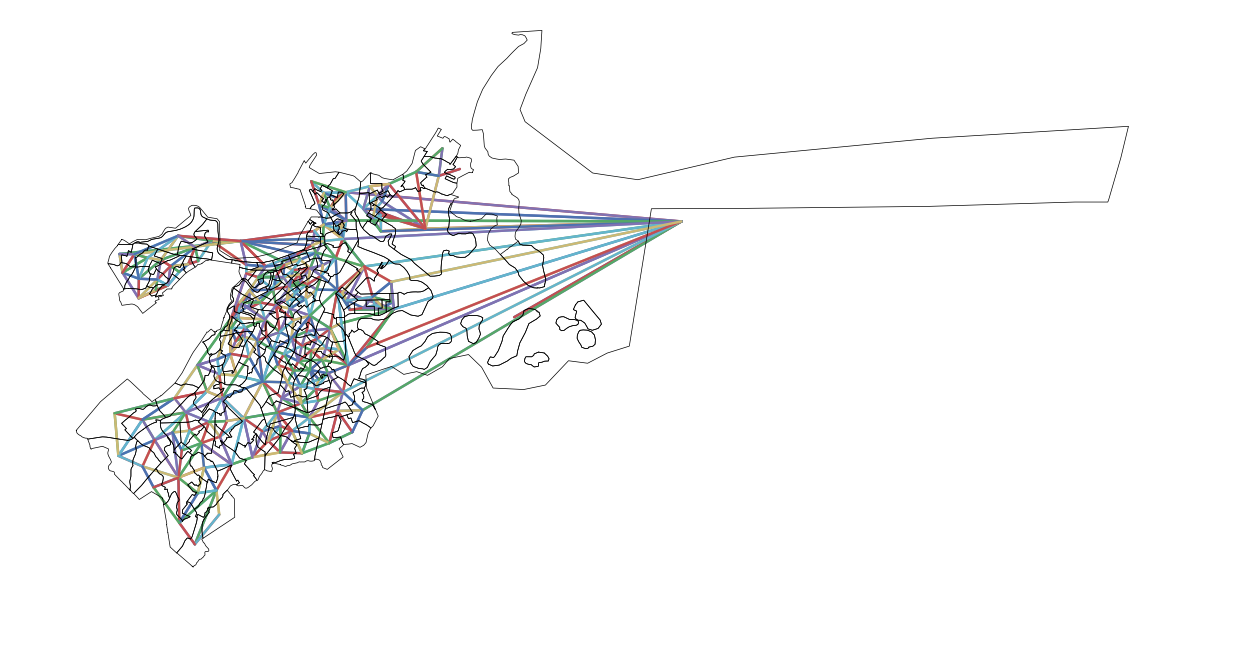

In [63]:

f = plt.figure(figsize=(15, 8))
ax = f.gca()

for i, (k, neighbors) in enumerate(qW.neighbors.items()):
    origin = boston.geometry.iloc[i].centroid
    for nabe_i in neighbors:
        nabe_centroid = boston.geometry.iloc[nabe_i].centroid
        plt.plot([origin.x, nabe_centroid.x], [origin.y, nabe_centroid.y], '-')

boston.plot(ax=ax, linewidth=0.5, facecolor='white')

ax.set_axis_off()

In [69]:
bnb_spatial_lags = ps.lag_spatial(qW, boston['BNBDensity'])
spatial_lag_classes = ps.Quantiles(bnb_spatial_lags, k=5)

In [70]:
spatial_lag_classes

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=   24.421               37
  24.421 < x[i] <=   59.602               36
  59.602 < x[i] <=  136.943               36
 136.943 < x[i] <=  281.667               36
 281.667 < x[i] <= 1132.690               36

In [71]:
spatial_lag_classes.yb


array([4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 3,
       3, 2, 4, 4, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 3, 4, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 3,
       3, 2, 1, 0, 4, 3, 1, 3, 2, 2, 3, 4, 4, 3, 1, 3, 4, 0, 0, 0, 2, 0, 0,
       1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 2, 3, 2, 0, 1, 0, 3, 2, 2, 3, 1,
       3, 2, 2, 3, 2, 2, 2, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 1, 2,
       3, 2, 3, 1, 4, 2, 2, 2, 2, 1, 1, 3, 4, 4, 4, 4, 4, 3, 4, 2])

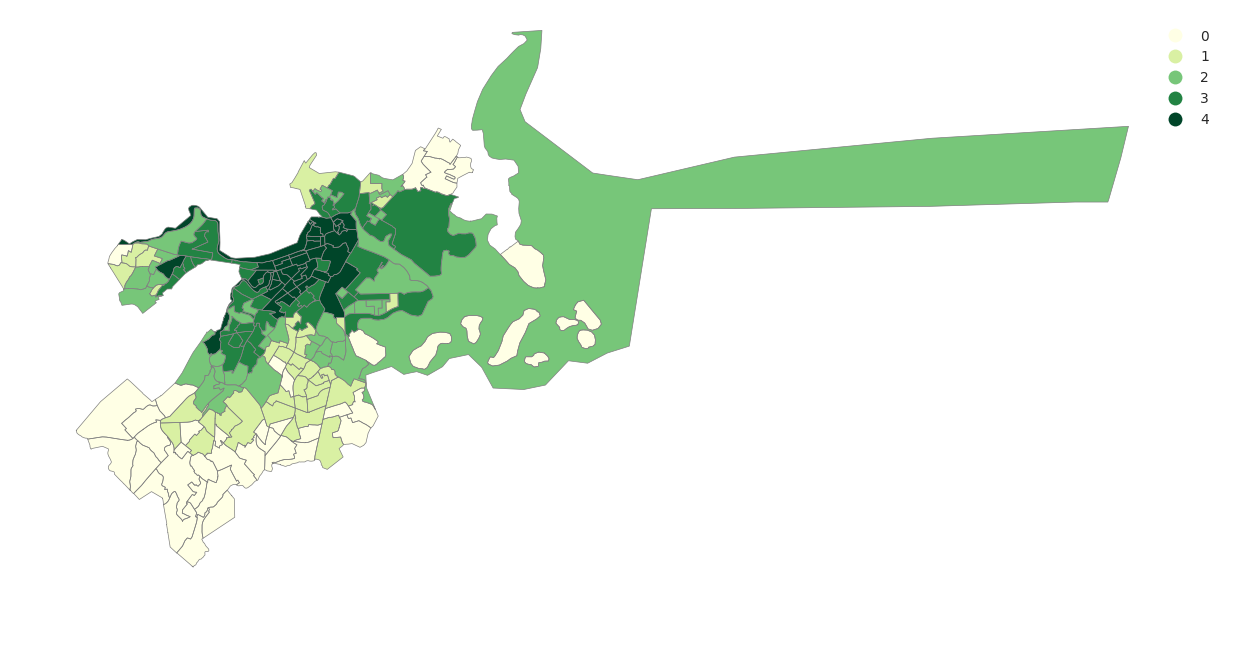

In [72]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='spatial_class', k=5, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5, 
          categorical=True)
boston.assign(spatial_class=spatial_lag_classes.yb).plot(ax=ax, **kw)
ax.set_axis_off()

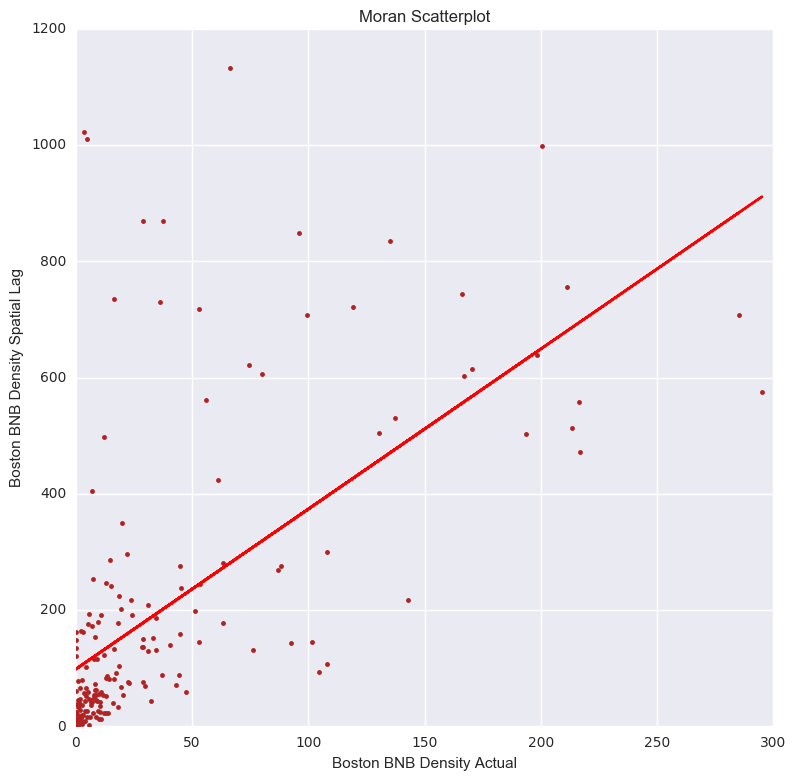

In [73]:

f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(boston['BNBDensity'], bnb_spatial_lags, '.', color='firebrick')

# Calculate and plot a line of best fit.
b,a = np.polyfit(boston['BNBDensity'], bnb_spatial_lags, 1)
plt.plot(boston['BNBDensity'], a + b*boston['BNBDensity'], 'r')

plt.title('Moran Scatterplot')
plt.ylabel('Boston BNB Density Spatial Lag')
plt.xlabel('Boston BNB Density Actual')
plt.show()

In [74]:
## Clustering

In [75]:
listings['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

In [79]:
apartments = listings.query('property_type == "Apartment" or property_type == "Condominium"').groupby('census_tract').count()['id']
houses = listings.query('property_type == "House" or property_type == "Townhouse"').groupby('census_tract').count()['id']

In [81]:
boston['BNBDensity_Houses'] = boston['NAMELSAD10'].map(houses).fillna(0)
boston['BNBDensity_Apartments'] = boston['NAMELSAD10'].map(apartments).fillna(0)

In [82]:
bnb_market = boston[['BNBDensity', 'BNBDensity_Houses', 'BNBDensity_Apartments']]

In [93]:
import sklearn.cluster
import sklearn.preprocessing

clf = sklearn.cluster.KMeans(n_clusters=3)
X = sklearn.preprocessing.scale(bnb_market.values)
classes = clf.fit(X)

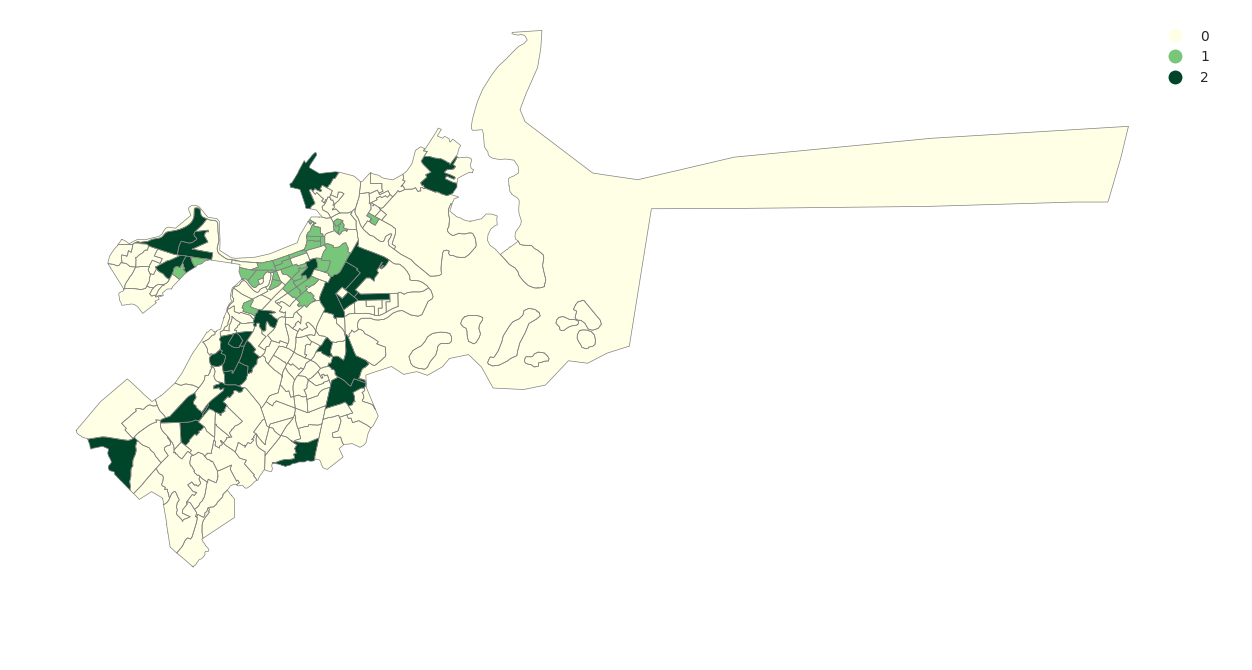

In [94]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='cluster', k=3, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5, categorical=True)
boston.assign(cluster=classes.labels_).plot(ax=ax, **kw)
ax.set_axis_off()

In [95]:
bnb_market.assign(cluster=classes.labels_).groupby('cluster').mean()


,BNBDensity,BNBDensity_Houses,BNBDensity_Apartments
cluster,,,
0,12.233624,2.062992,6.740157
1,149.154101,1.571429,47.464286
2,31.235665,11.615385,23.884615


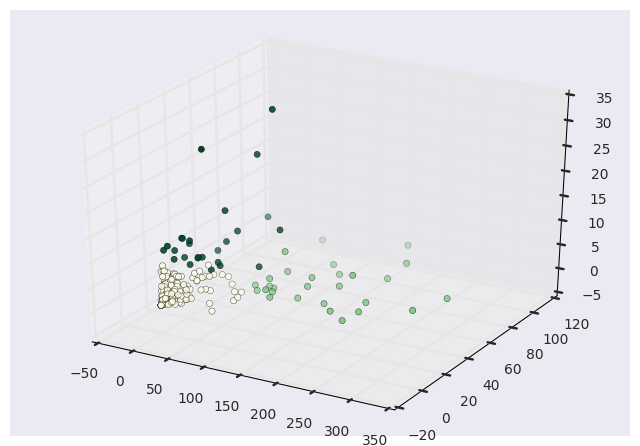

In [96]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bnb_market['BNBDensity'], bnb_market['BNBDensity_Apartments'],
           zs=bnb_market['BNBDensity_Houses'], c=classes.labels_, cmap='YlGn')

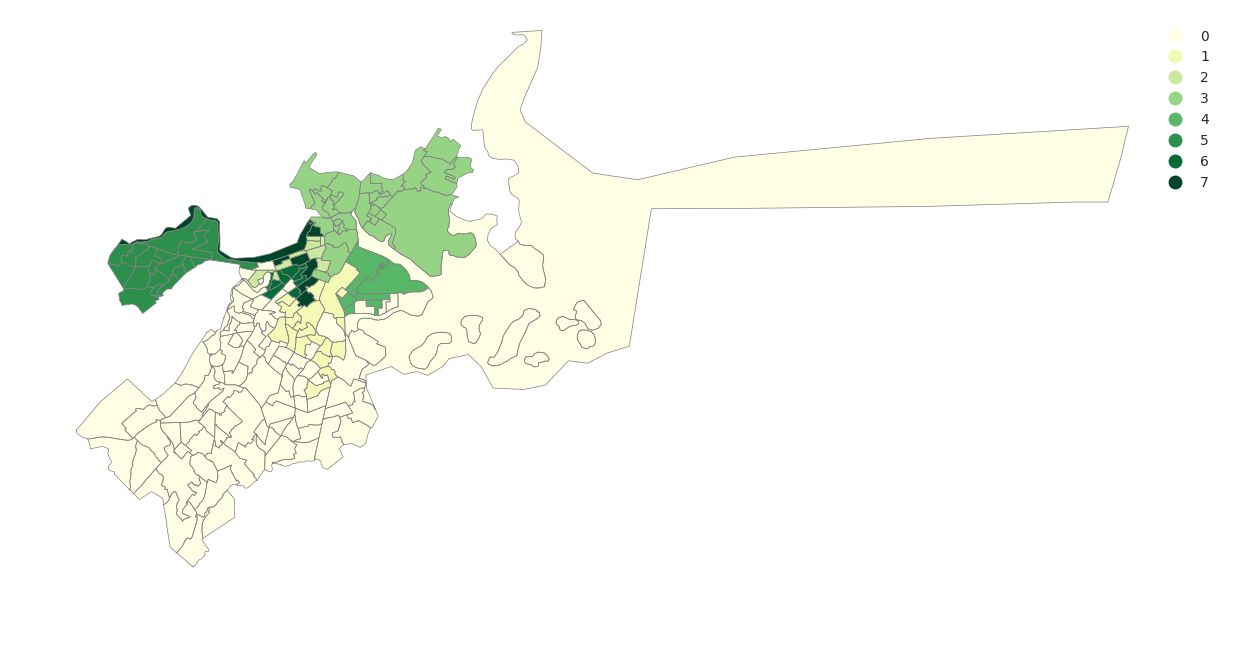

In [106]:

# n = 200
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='cluster', k=10, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5, categorical=True)
boston.assign(cluster=clf.area2region.values()).plot(ax=ax, **kw)
ax.set_axis_off()

In [103]:
clf = ps.region.Maxp(qW, bnb_market.values, 150, boston['BNBs'].values[:,None])


In [104]:
bnb_market.assign(cluster=clf.area2region.values()).groupby('cluster').mean()


,BNBDensity,BNBDensity_Houses,BNBDensity_Apartments
cluster,,,
0,14.952000,3.659091,8.477273
1,12.101414,2.777778,6.500000
2,187.697357,1.000000,55.333333
3,44.976129,1.928571,18.142857
4,26.975896,4.666667,21.333333
5,31.148201,6.500000,17.000000
6,116.643145,1.714286,37.428571
7,74.411154,2.285714,34.428571
